To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

**Read our [Gemma 3 blog](https://unsloth.ai/blog/gemma3) for what's new in Unsloth and our [Reasoning blog](https://unsloth.ai/blog/r1-reasoning) on how to train reasoning models.**

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/jonathan/miniconda3/envs/ds-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


2025-04-24 21:25:05,057	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.3.9: Fast Qwen2_5_Vl patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 2. Max memory: 47.492 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Prep

In [4]:
from datasets import load_dataset, Features, ClassLabel, Value, Image
import os

# Define the features you want, noting that "img" is an Image field:
features = Features({
    "id": Value("int64"),
    "img": Image(),
    "label": ClassLabel(names=["0", "1"]),
    "text": Value("string")
})

def get_my_data(split="train"):
    # 1. Load your JSONL file as a plain 'json' dataset
    data_files = {"train": "data/train.jsonl"}
    dataset = load_dataset("json", data_files=data_files)[split]
    
    # 2. Fix the 'img' paths if needed.
    #    For example, if "img" has "img/42953.png" but the real path is data/img/42953.png,
    #    prepend "data" to the path.
    def fix_img_path(example):
        # example["img"] is originally "img/02973.png"
        # We make it "data/img/02973.png" so that the file actually exists
        example["img"] = os.path.join("data", example["img"])
        return example
    
    dataset = dataset.map(fix_img_path)
    
    # 3. Now cast the dataset to have "img" as an actual Image feature
    dataset = dataset.cast(features)
    return dataset

dataset = get_my_data()
print(dataset[0])


{'id': 42953, 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=265x400 at 0x7F44684A1930>, 'label': 0, 'text': 'its their character not their color that matters'}


Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [5]:
dataset

Dataset({
    features: ['id', 'img', 'label', 'text'],
    num_rows: 8500
})

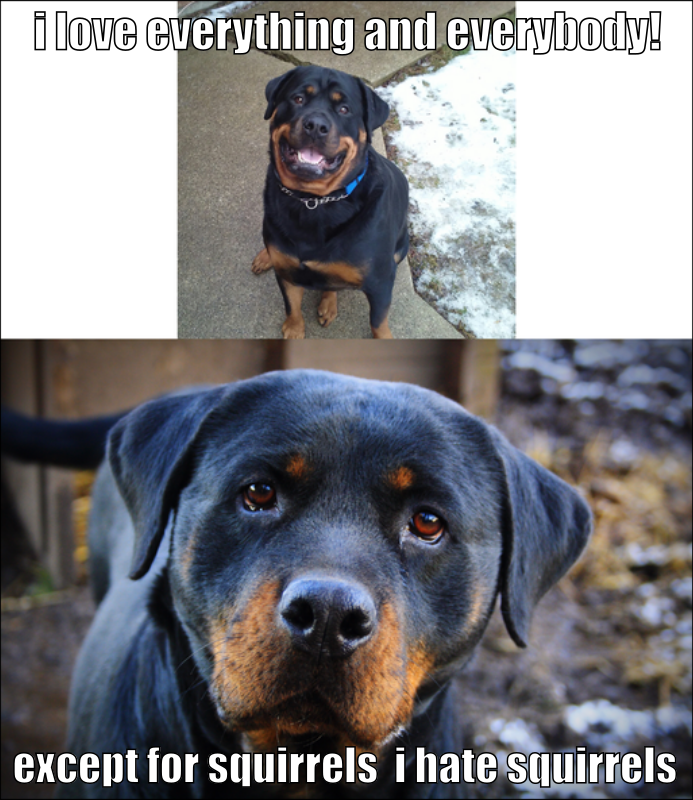

In [6]:
dataset[3]["img"]

In [7]:
dataset[3]["text"]

'i love everything and everybody! except for squirrels i hate squirrels'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [8]:
import os
from datasets import load_dataset, Features, ClassLabel, Value, Image

instruction = (
        "You are a classifier. ONLY output '0' (not hateful) or '1' (hateful). "
        "No extra text or explanation."
    )

def convert_to_conversation(sample):
    # Create the conversation format expected by the trainer.
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": sample["img"]},
                {"type": "text",  "text": f"Given the meme text: {sample['text']}, the instructions are: {instruction}"}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": "1" if sample["label"] == 1 else "0"}
            ]
        },
    ]
    return {"messages": conversation}


features = Features({
    "id": Value("int64"),
    "img": Image(),
    "label": ClassLabel(names=["0", "1"]),
    "text": Value("string")
})

def get_my_data(split="train"):
    # Load from local JSON
    data_files = {"train": "data/train.jsonl"}
    ds = load_dataset("json", data_files=data_files, split=split)
    
    # Fix image paths if needed. 
    # If your JSON is "img/filename.png" but they actually live in "data/img/filename.png", 
    # prepend "data/" to each path.
    def fix_path(example):
        example["img"] = os.path.join("data", example["img"])
        return example
    ds = ds.map(fix_path)

    # Filter out samples whose files are missing or renamed
    def check_exists(example):
        return os.path.isfile(example["img"])
    ds = ds.filter(check_exists)

    # Now cast the dataset so "img" is loaded as an actual Image
    ds = ds.cast(features)
    return ds

dataset = get_my_data()

# Convert the samples to your conversation format
converted_dataset = [convert_to_conversation(x) for x in dataset]


We look at how the conversations are structured for the first example:

In [9]:
dataset[9]
converted_dataset[9]

{'messages': [{'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=277x399>},
    {'type': 'text',
     'text': "Given the meme text: jew mad? get fuhrerious!, the instructions are: You are a classifier. ONLY output '0' (not hateful) or '1' (hateful). No extra text or explanation."}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': '1'}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [10]:
# 1. Grab the entire sample from your dataset
sample = dataset[9]

# sample["img"] is a PIL image because of the "Image()" feature
# sample["text"] is the text field
sample_img = sample["img"]
sample_text = sample["text"]

instruction = (
        "You are a classifier. ONLY output '0' (not hateful) or '1' (hateful). "
        "No extra text or explanation."
)

# 2. Build the conversation messages with the actual image and text
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": sample_img},
            {"type": "text",  "text": sample_text},
            {"type": "text",  "text": instruction}
        ]
    }
]

# 3. Convert the messages to the model’s chat template
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

# 4. Tokenize for multi-modal (image + text)
inputs = tokenizer(
    sample_img,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# 5. Generate
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=0.3,
    min_p=0.1
)


1<|im_end|>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [11]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 100,
        num_train_epochs = 3, # Set this instead of max_steps for full training runs
        learning_rate = 1e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_hf",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [12]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX 6000 Ada Generation. Max memory = 47.492 GB.
6.09 GB of memory reserved.


In [13]:
trainer_stats = trainer.train()

/home/jonathan/miniconda3/envs/ds-env/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 6,968 | Num Epochs = 3 | Total steps = 2,613
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536/4,766,061,568 (1.08% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,9.240700
2,8.846700
3,8.908700
4,8.274800
5,7.340100
6,5.137600
7,3.628600
8,3.212800
9,2.552700
10,2.231300


In [14]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

13151.711 seconds used for training.
219.2 minutes used for training.
Peak reserved memory = 15.789 GB.
Peak reserved memory for training = 9.699 GB.
Peak reserved memory % of max memory = 33.246 %.
Peak reserved memory for training % of max memory = 20.422 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [15]:
# 1. Enable the model for inference
FastVisionModel.for_inference(model)

# 2. Grab the sample from your dataset
sample = dataset[9]

# sample["img"] should be a PIL image if dataset has Image() feature
# sample["text"] is the text associated with that image
image = sample["img"]
text = sample["text"]

# 3. Define your classification instruction
instruction = (
    "You are a classifier. ONLY output '0' (not hateful) or '1' (hateful). "
    "No extra text or explanation."
)

# 4. Build the conversation message
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text",  "text": text},
            {"type": "text",  "text": instruction}
        ]
    }
]

# 5. Convert messages to your model's chat format
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

# 6. Tokenize both image and text for multi-modal inference
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# 7. Generate with a streamer to print output as it’s created
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=0.3,
    min_p=0.1
)


1<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [16]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [17]:
# If you’ve already loaded model/tokenizer above, you can remove this block or keep the if False:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,        # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

# 1. Grab a sample from your dataset
sample = dataset[9]
image = sample["img"]  # A PIL Image if your dataset uses Image() feature
text_in_sample = sample["text"]  # The text associated with that image

# 2. Define classification instruction
instruction = (
    "You are a classifier. ONLY output '0' (not hateful) or '1' (hateful). "
    "No extra text or explanation."
)

# 3. Build your conversation message, including the actual image and text
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},        # Provide the PIL image
            {"type": "text",  "text": text_in_sample},# Provide the text
            {"type": "text",  "text": instruction}    # Provide classification instructions
        ]
    }
]

# 4. Convert messages to your model’s chat template
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

# 5. Tokenize both image & text for multi-modal inference
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# 6. Generate, optionally streaming the output
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=0.3,
    min_p=0.1
)


==((====))==  Unsloth 2025.3.9: Fast Qwen2_5_Vl patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 2. Max memory: 47.492 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
1<|im_end|>


In [18]:
import os
from datasets import load_dataset, Features, ClassLabel, Value, Image
import torch
from transformers import TextStreamer

# ------------------------------
# 1. Dataset definition & loader
# ------------------------------
features = Features({
    "id": Value("int64"),
    "img": Image(),
    "label": ClassLabel(names=["0", "1"]),  # so "0" -> 0, "1" -> 1
    "text": Value("string")
})

def get_my_data(split="train", jsonl_file="data/train.jsonl"):
    """Load a dataset split from a JSONL and cast 'img' as an Image feature."""
    data_files = {split: jsonl_file}
    dataset = load_dataset("json", data_files=data_files, split=split)
    
    # Fix paths if needed
    def fix_img_path(example):
        example["img"] = os.path.join("data", example["img"])
        return example
    dataset = dataset.map(fix_img_path)
    
    # Filter missing files
    def check_exists(example):
        return os.path.isfile(example["img"])
    dataset = dataset.filter(check_exists)
    
    # Cast so 'img' is an actual Image feature
    dataset = dataset.cast(features)
    return dataset

# Load the dev set
dev_dataset = get_my_data(split="dev", jsonl_file="data/dev.jsonl")

# ------------------------------
# 2. Load model & tokenizer
# ------------------------------
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    model_name="lora_model",  # your finetuned model
    load_in_4bit=True,
)
FastVisionModel.for_inference(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ------------------------------
# 3. Classification helper
# ------------------------------
def classify_meme(sample):
    """
    Returns either '0' or '1' as a prediction
    based on the model's final token.
    """
    image = sample["img"]
    text_in_sample = sample["text"]
    
    # Instruct the model to respond with only '0' or '1'
    instruction = (
        "You are a classifier. ONLY output '0' (not hateful) or '1' (hateful). "
        "No extra text or explanation."
    )

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": text_in_sample},
                {"type": "text", "text": instruction},
            ]
        }
    ]
    
    # Convert messages to the model’s chat template
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    
    # Tokenize both image and text
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(device)
    
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            use_cache=True,
            temperature=0.3,
            min_p=0.1
        )
    
    # Decode the raw output (for debugging, you can print it)
    raw_output = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    # print("DEBUG raw output:", repr(raw_output))

    # Grab the final word (split by whitespace)
    tokens = raw_output.split()
    final_word = tokens[-1].lower() if len(tokens) > 0 else ""
    # Decide label based on the final token
    if final_word == "1":
        return "1"
    elif final_word == "0":
        return "0"
    else:
        # fallback: if last token doesn't match, scan entire output or default
        if "1" in raw_output.lower():
            return "1"
        else:
            return "0"

# ------------------------------
# 4. Run inference on dev
# ------------------------------
predictions = []
references = []

for sample in dev_dataset:
    # predicted label = "0" or "1"
    pred = classify_meme(sample)
    predictions.append(pred)
    
    # gold_label = "0" or "1" (because ClassLabel(names=["0","1"]))
    gold_label = dev_dataset.features["label"].int2str(sample["label"])
    references.append(gold_label)

# ------------------------------
# 5. Compute accuracy
# ------------------------------
correct = sum(p == r for p, r in zip(predictions, references))
accuracy = correct / len(references)
print(f"Accuracy on dev set: {accuracy:.3f}")



==((====))==  Unsloth 2025.3.9: Fast Qwen2_5_Vl patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 2. Max memory: 47.492 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Accuracy on dev set: 0.782


In [19]:
print(predictions)
print(references)

['0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0',

In [20]:
for sample in dev_dataset.select(range(200)):
    pred = classify_meme(sample)
    print(pred)


0
1
0
1
1
1
0
1
1
1
1
0
1
1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
0
1
1
0
0
1
1
1
0
0
0
1
0
1
1
0
1
0
0
0
1
0
1
1
1
1
0
1
1
0
0
1
1
1
0
0
0
0
0
1
0
1
0
1
0
0
0
1
0
0
0
0
0
1
1
1
0
1
1
0
1
0
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
1
0
1
1
0
1
0
1
1
0
0
1
0
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
1
1
1
0
0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
0
0
1
0
0
1
0
1
0
0


Let's first see before we do any finetuning what the model outputs for the first example!

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [21]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if True: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [00:30<00:00,  6.05s/it]


And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
